In [1]:
import sys, os, pickle
import numpy as np

sys.path.insert(0, './src')
sys.path.insert(0, '/home/lponzoni/Data/016-RAPSODY_v2-integration_with_Prody/ProDy/')

# Import experimental data

In [2]:
import csv, glob

data = {}
for f in glob.glob('SI_data/*csv'):
    fname = os.path.basename(f, )
    case = fname.replace('.csv', '')
    with open(f, 'r') as _f:
        reader = csv.reader(_f)
        data[case] = list(reader)
        
exp_sequence = ''.join(data['attenuated_RAS'][1])

The sequence used in the experiments is a substring of the Uniprot sequence:

In [3]:
from prody import queryUniprot

acc = 'P01112'
sequence = queryUniprot(acc)['sequence   0'].replace('\n', '')

In [4]:
exp_sequence == sequence[1: len(exp_sequence)+1]

True

# RHAPSODY

In [5]:
from interfaces import *
pathRhapsodyFolder('./pickles')

@> Local Rhapsody folder is set: '/home/lponzoni/Scratch/029-RHAPSODY_applications/01-RAS/pickles'


It turns out that some mutations are found in the Integrated Dataset, so I should retrain the classifiers. Here however I don't do that (see end of notebook for how to do that).

### run rhapsody with different classifiers
It computes predictions from Rhapsody (with auxiliary classifier) and Rhapsody combined with EVmutation epistatic score.

### Active *vs* inactive state
Rhapsody automatically maps variants onto PDB `4Q21`, which is the GDP-complexed **inactive** structure. What happens when using the **active** (GTP-bound) structure `6Q21`?

In [10]:
r_full   = pickle.load(open('results/rhapsody-pickle.pkl', 'rb'))
r_EVmut  = pickle.load(open('results-EVmut/rhapsody-pickle.pkl', 'rb'))
r_active = pickle.load(open('results-active_state/rhapsody-pickle.pkl', 'rb'))

### Recover  PolyPhen-2  and  EVmutation scores
**NB:** I define `EVmut_score` as $- \Delta$E.

In [7]:
PP2_probs = np.array([float(l['pph2_prob']) for l in r_full.PP2output])
PP2_DeltaPSIC = r_full.featMatrix[:,1]
EVmut_score = - r_EVmut.featMatrix[:,-1]

# Figures
### Inactive/active 

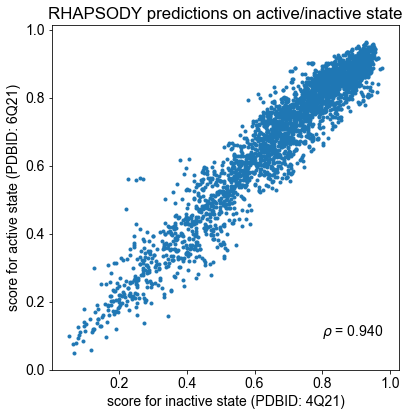

In [28]:
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

score_inactive = r_full.mixedPreds['score']
score_active =   r_active.mixedPreds['score']

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(score_inactive, score_active, marker='.')
ax.set_xlabel('score for inactive state (PDBID: 4Q21)')
ax.set_ylabel('score for active state (PDBID: 6Q21)')

sel = np.logical_and(~np.isnan(score_inactive), ~np.isnan(score_active))
rho = spearmanr(score_inactive[sel], score_active[sel])[0]

s = r'$\rho$'
ax.set_title('RHAPSODY predictions on active/inactive state')
ax.text(0.8, 0.1, f'{s} = {rho:5.3f}')

fig.tight_layout()
plt.savefig(f'figures/active_vs_inactive_correlation.png', dpi=300)

### Correlation with experiments

In [23]:
tables = {}

for case, d in data.items():
    resids = d[0][1:]
    wt_aas = d[1][1:]
    table = {}
    for line in d[2:]:
        mut_aa = line[0]
        for i, x in enumerate(line[1:]):
            resid = int(resids[i])
            wt_aa = wt_aas[i]
            table[f'P01112 {resid} {wt_aa} {mut_aa}'] = float(x)
    tables[case] = table

In [24]:
SAV_coords = r_full.SAVcoords['text']

exp_scores = {}
for case, table in tables.items():
    a = np.zeros(len(SAV_coords))
    a[:] = np.nan
    for i, SAV in enumerate(SAV_coords):
        if SAV in table:
            a[i] = table[SAV]
    exp_scores[case] = a

In [25]:
exp_scores

{'regulated_RAS': array([nan, nan, nan, ..., nan, nan, nan]),
 'unregulated_RAS': array([nan, nan, nan, ..., nan, nan, nan]),
 'attenuated_RAS': array([nan, nan, nan, ..., nan, nan, nan]),
 'G12V_RAS': array([nan, nan, nan, ..., nan, nan, nan])}

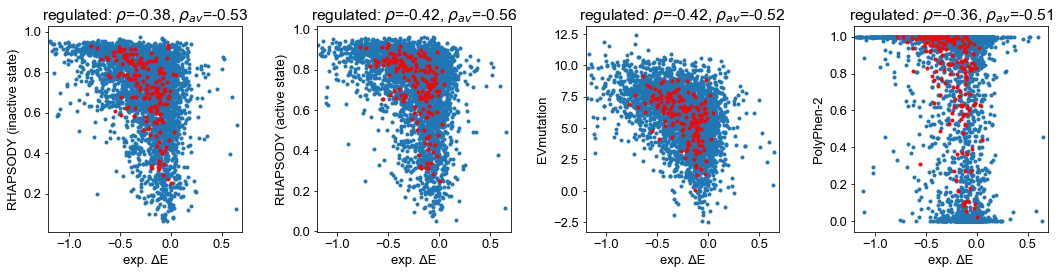

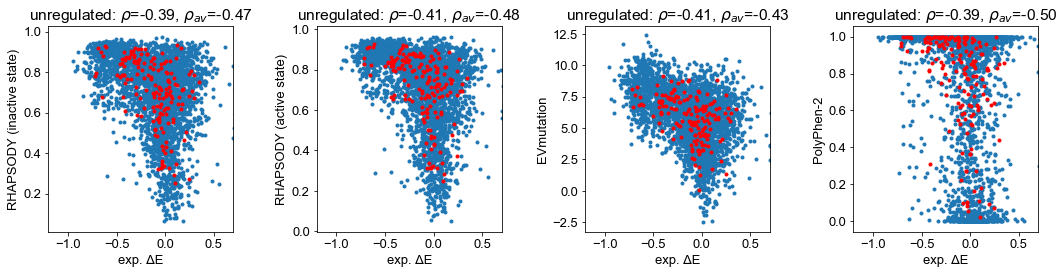

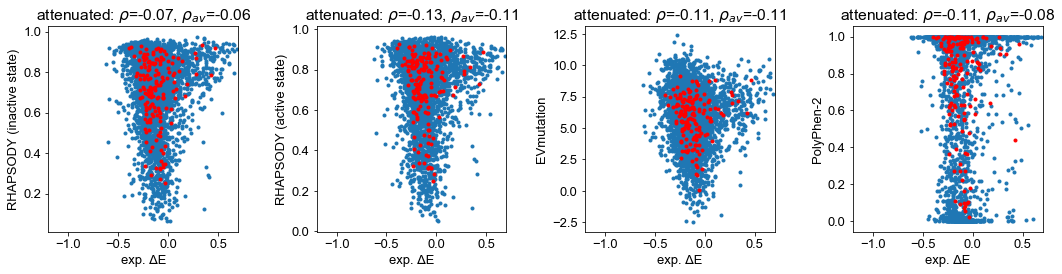

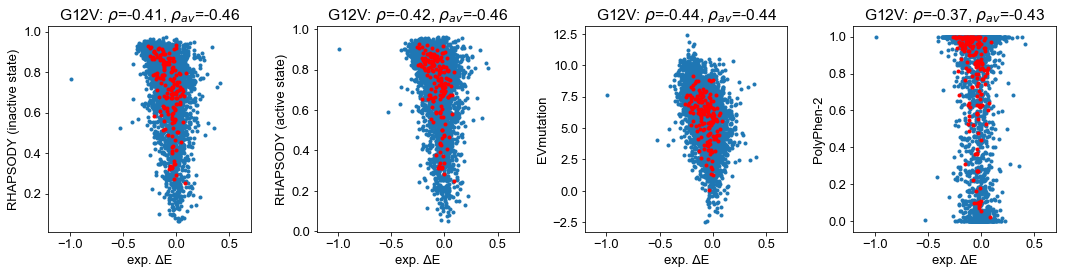

In [32]:
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.family': 'Arial'})

rhaps_score = r_full.mixedPreds['score']
rhaps_score_act = r_active.mixedPreds['score']
avg_rhaps_score = np.mean(rhaps_score.reshape((-1, 19)), axis=1)
avg_rhaps_score_act = np.mean(rhaps_score_act.reshape((-1, 19)), axis=1)
avg_EVmut_score = np.mean(EVmut_score.reshape((-1, 19)), axis=1)
avg_PP2_probs   = np.mean(PP2_probs.reshape((-1, 19)),   axis=1)

for case, exp_score in exp_scores.items():
    
    avg_exp_score = np.mean(exp_score.reshape((-1, 19)), axis=1)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))
    ax1.scatter(exp_score, rhaps_score, marker='.')
    ax2.scatter(exp_score, rhaps_score_act, marker='.')
    ax3.scatter(exp_score, EVmut_score, marker='.')
    ax4.scatter(exp_score, PP2_probs, marker='.')
    ax1.scatter(avg_exp_score, avg_rhaps_score, marker='.', c='r')
    ax2.scatter(avg_exp_score, avg_rhaps_score_act, marker='.', c='r')
    ax3.scatter(avg_exp_score, avg_EVmut_score, marker='.', c='r')
    ax4.scatter(avg_exp_score, avg_PP2_probs,   marker='.', c='r')    
    ax1.set_ylabel('RHAPSODY (inactive state)')
    ax2.set_ylabel('RHAPSODY (active state)')
    ax3.set_ylabel('EVmutation')
    ax4.set_ylabel('PolyPhen-2')

    rho = []
    for i,s in enumerate([rhaps_score, rhaps_score_act, EVmut_score, PP2_probs]):
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(s))
        rho.append( spearmanr(exp_score[sel], s[sel])[0] )
    rho_av = []
    for i,s in enumerate([avg_rhaps_score, avg_rhaps_score_act, avg_EVmut_score, avg_PP2_probs]):
        sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(s))
        rho_av.append( spearmanr(avg_exp_score[sel], s[sel])[0] )
    
    s1 = r'$\rho$'
    s2 = r'$\rho_{av}$'
    c  = case.split('_')[0]
    ax1.set_title(f'{c}: {s1}={rho[0]:5.2f}, {s2}={rho_av[0]:5.2f}')
    ax2.set_title(f'{c}: {s1}={rho[1]:5.2f}, {s2}={rho_av[1]:5.2f}')
    ax3.set_title(f'{c}: {s1}={rho[2]:5.2f}, {s2}={rho_av[2]:5.2f}')
    ax4.set_title(f'{c}: {s1}={rho[3]:5.2f}, {s2}={rho_av[3]:5.2f}')
    for ax in (ax1, ax2, ax3, ax4):
        ax.set_xlim((-1.2, 0.7))
        ax.set_xlabel('exp. ΔE')
    fig.tight_layout()
    plt.savefig(f'figures/correlation-{case}.png', dpi=300)

### Mutagenesis table - inactive state
We would like to generate a 20xN matrix (where N is the number of residues) of pathogenicity scores, and take averages of each column, and compare with data on the effect of certain positions in function, multimerization etc.

In [56]:
JoptEV = 4.551

In [57]:
probs_full   = r_full.predictions['path. probability']
probs_noPfam = r_full.auxPreds['path. probability']
probs_mixed  = r_full.mixedPreds['path. probability']

In [58]:
# create empty (20 x num_res) table
num_res = r_full.SAVcoords['pos'][-1]
mut_table = np.zeros((20, num_res), dtype=float)
mut_table[:] = 'nan'
mut_table.shape

(20, 189)

In [59]:
# fill table with predicted probability:
#      1: deleterious
#      0: neutral
# 'nan' : no prediction/wt
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_map  = {aa: i for i, aa in enumerate(aa_list)}
for i, SAV in enumerate(r_full.SAVcoords):
    mut_table[aa_map[SAV['aa_mut']], SAV['pos']-1] = probs_mixed[i]

In [60]:
# profile of average pathogenicity
_m = probs_mixed.reshape((-1, 19)).T
avg_profile = np.nanmean(_m, axis=0)
min_profile = np.nanmin( _m, axis=0)
max_profile = np.nanmax( _m, axis=0)
# average profile where all features are available
_m = probs_full.reshape((-1, 19)).T
avg_profile_full = np.nanmean(_m, axis=0)

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN slice encountered
  """
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [61]:
# normalize EVmutation score (i.e. -ΔE) so that wt=0 and max=100 
# then compute the average over 19 variants
_m = EVmut_score.reshape((-1, 19)).T
avg_EVmut_score = np.nanmean(_m, axis=0)/np.nanmax(EVmut_score)
print('range: {:5.3f} {:5.3f}'.format(np.nanmin(avg_EVmut_score), np.nanmax(avg_EVmut_score)))

range: 0.002 0.738


/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [62]:
# BETTER: Normalize EVmutation score so that the optimal cutoff is mapped to 0.5
_m = EVmut_score.reshape((-1, 19)).T
avg_EVmut_score = np.nanmean(_m, axis=0)/JoptEV*.5
print('range: {:5.3f} {:5.3f}'.format(np.nanmin(avg_EVmut_score), np.nanmax(avg_EVmut_score)))

range: 0.003 1.004


/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
# compute Spearman corr. coeff. between rhapsody and EVmutation
sel = np.logical_and(~np.isnan(avg_EVmut_score), ~np.isnan(avg_profile))
rho = spearmanr(avg_EVmut_score[sel], avg_profile[sel])[0]

In [64]:
PDB_lengths = [int(t[2][4]) if isinstance(t[2], tuple) else np.nan for t in r_full.Uniprot2PDBmap]

In [65]:
upper_strip = np.zeros((2, mut_table.shape[1]))
upper_strip[:] = np.nan
upper_strip[0,:] = np.array(PDB_lengths).reshape((-1, 19))[:,0]

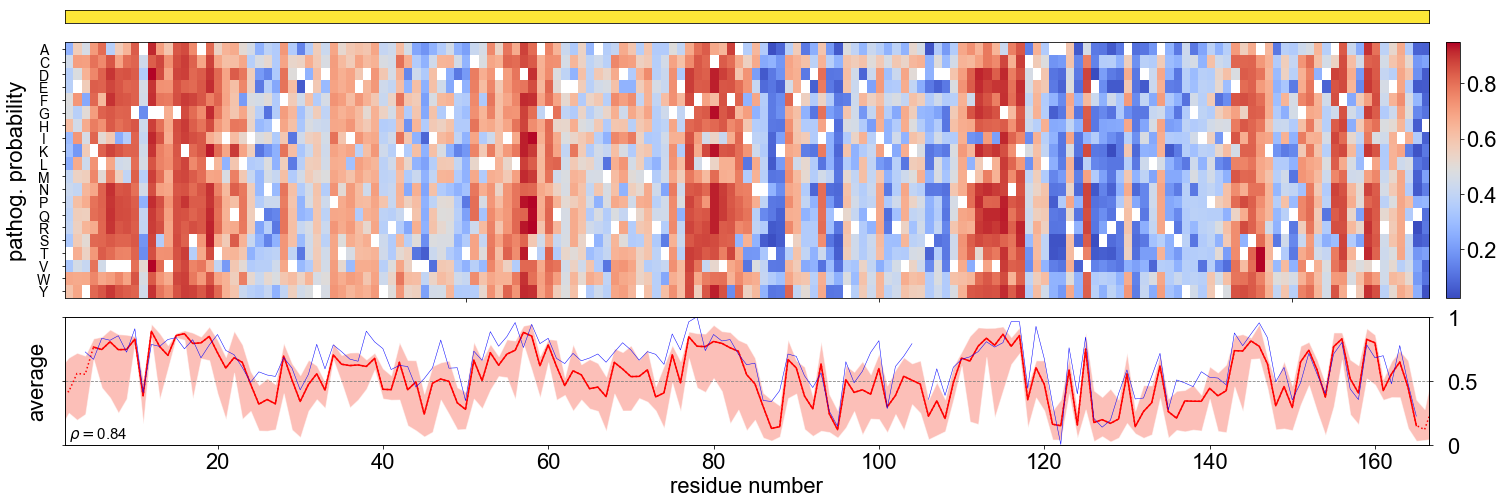

In [66]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 22, 'font.family': 'Arial'})

# portions of the sequence to display
min_resid = np.where(~np.isnan(avg_profile))[0][0]  + 1
max_resid = np.where(~np.isnan(avg_profile))[0][-1] + 1
third = int((max_resid - min_resid)/3) + 1
segments = {
#              'whole'      : (min_resid, max_resid),
             'whole'      : (2, 166),
}

for seg, (res_i, res_f) in segments.items():

    fig, ax = plt.subplots(3, 2, figsize=(25,8))
    plt.subplots_adjust(wspace=0.025, hspace=0.15)

    # figure structure
    gs = gridspec.GridSpec(3, 2, width_ratios=[100, 1], height_ratios=[1, 20, 10])
    ax0  = plt.subplot(gs[0, 0]) # secondary structure strip
    ax1  = plt.subplot(gs[1, 0]) # mutagenesis table
    axcb = plt.subplot(gs[1, 1]) # colorbar
    ax2  = plt.subplot(gs[2, 0]) # average profile

    # secondary structure strip
#     ax0.imshow(upper_strip[:, res_i-1:res_f], aspect='auto', cmap='gist_rainbow')
    ax0.imshow(upper_strip[:, res_i-1:res_f], aspect='auto', cmap='cividis_r')
    ax0.set_ylim((-0.45, .45))
    ax0.set_yticks([])
    ax0.set_xticks([])
    
    # mutagenesis table (heatmap)
    matplotlib.cm.coolwarm.set_bad(color='white')
    im = ax1.imshow(mut_table[:, res_i-1:res_f], aspect='auto', cmap='coolwarm')
    axcb.figure.colorbar(im, cax=axcb)
    ax1.set_yticks(np.arange(len(aa_list)))
    ax1.set_yticklabels(aa_list, ha='center', position=(-.01,0), fontsize=14)
    ax1.set_xticks(np.arange(50-res_i%50, res_f-res_i+10, 50))
    ax1.set_xticklabels([])
    ax1.set_ylabel('pathog. probability', labelpad=10)

    # average pathogenicity profile
    x_resids = np.arange(1, len(avg_profile)+1)
    # cutoff line
    ax2.hlines(0.5, -.5, len(avg_profile)+.5, colors='grey', lw=.8, linestyle='dashed')
    # solid line for predictions obtained with full classifier
    ax2.plot(x_resids, avg_profile_full, color='red')
    # dotted line for predictions obtained with reduced classifier, without Pfam features
    _p = np.where(np.isnan(avg_profile_full), avg_profile, avg_profile_full)
    ax2.plot(x_resids, _p, color='red', ls='dotted')
    # shading showing range of values
    ax2.fill_between(x_resids, min_profile, max_profile, alpha=0.5, edgecolor='white', facecolor='salmon')
    # EVmutation profile
    ax2.plot(x_resids, avg_EVmut_score, color='blue', lw=.5)

    ax2.text(res_i, 0.05, r'$\rho=${:4.2f}'.format(rho), fontsize=15)
    ax2.set_xlim((res_i-.5, res_f+.5))
    ax2.set_xlabel('residue number')
    ax2.set_ylim((0, 1))
    ax2.set_ylabel('average', rotation=90, labelpad=10)
    ax2.set_yticklabels([])
    ax2r = ax2.twinx()
    ax2r.set_yticks([0, .5, 1])
    ax2r.set_yticklabels(['0', '0.5', '1'])
    ax2r.tick_params(axis='both', which='major', pad=15)
    
    # fig.tight_layout()
    plt.show()
    fig.savefig('figures/mutagenesis_table-inactive.png', dpi=300)

### Mutagenesis table - active state
We would like to generate a 20xN matrix (where N is the number of residues) of pathogenicity scores, and take averages of each column, and compare with data on the effect of certain positions in function, multimerization etc.

In [44]:
JoptEV = 4.551

In [45]:
probs_full   = r_active.predictions['path. probability']
probs_noPfam = r_active.auxPreds['path. probability']
probs_mixed  = r_active.mixedPreds['path. probability']

In [46]:
# create empty (20 x num_res) table
num_res = r_full.SAVcoords['pos'][-1]
mut_table = np.zeros((20, num_res), dtype=float)
mut_table[:] = 'nan'
mut_table.shape

(20, 189)

In [47]:
# fill table with predicted probability:
#      1: deleterious
#      0: neutral
# 'nan' : no prediction/wt
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_map  = {aa: i for i, aa in enumerate(aa_list)}
for i, SAV in enumerate(r_full.SAVcoords):
    mut_table[aa_map[SAV['aa_mut']], SAV['pos']-1] = probs_mixed[i]

In [48]:
# profile of average pathogenicity
_m = probs_mixed.reshape((-1, 19)).T
avg_profile = np.nanmean(_m, axis=0)
min_profile = np.nanmin( _m, axis=0)
max_profile = np.nanmax( _m, axis=0)
# average profile where all features are available
_m = probs_full.reshape((-1, 19)).T
avg_profile_full = np.nanmean(_m, axis=0)

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN slice encountered
  """
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [49]:
# normalize EVmutation score (i.e. -ΔE) so that wt=0 and max=100 
# then compute the average over 19 variants
_m = EVmut_score.reshape((-1, 19)).T
avg_EVmut_score = np.nanmean(_m, axis=0)/np.nanmax(EVmut_score)
print('range: {:5.3f} {:5.3f}'.format(np.nanmin(avg_EVmut_score), np.nanmax(avg_EVmut_score)))

range: 0.002 0.738


/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [50]:
# BETTER: Normalize EVmutation score so that the optimal cutoff is mapped to 0.5
_m = EVmut_score.reshape((-1, 19)).T
avg_EVmut_score = np.nanmean(_m, axis=0)/JoptEV*.5
print('range: {:5.3f} {:5.3f}'.format(np.nanmin(avg_EVmut_score), np.nanmax(avg_EVmut_score)))

range: 0.003 1.004


/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
# compute Spearman corr. coeff. between rhapsody and EVmutation
sel = np.logical_and(~np.isnan(avg_EVmut_score), ~np.isnan(avg_profile))
rho = spearmanr(avg_EVmut_score[sel], avg_profile[sel])[0]

In [52]:
PDB_lengths = [int(t[2][4]) if isinstance(t[2], tuple) else np.nan for t in r_full.Uniprot2PDBmap]

In [53]:
upper_strip = np.zeros((2, mut_table.shape[1]))
upper_strip[:] = np.nan
upper_strip[0,:] = np.array(PDB_lengths).reshape((-1, 19))[:,0]

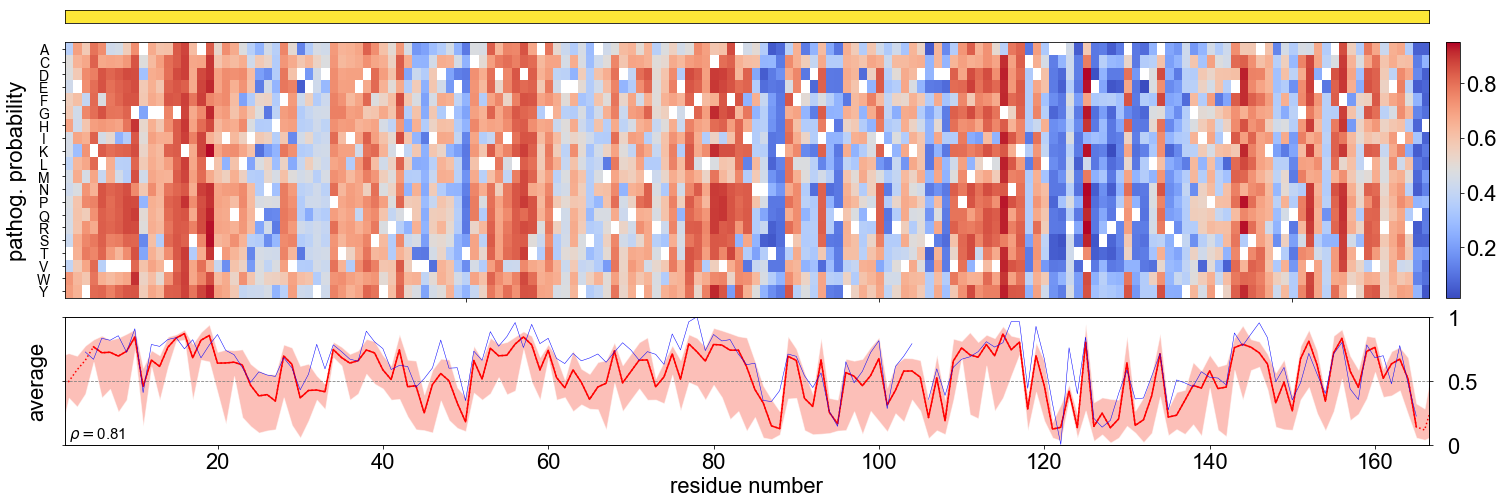

In [55]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 22, 'font.family': 'Arial'})

# portions of the sequence to display
min_resid = np.where(~np.isnan(avg_profile))[0][0]  + 1
max_resid = np.where(~np.isnan(avg_profile))[0][-1] + 1
third = int((max_resid - min_resid)/3) + 1
segments = {
#              'whole'      : (min_resid, max_resid),
             'whole'      : (2, 166),
}

for seg, (res_i, res_f) in segments.items():

    fig, ax = plt.subplots(3, 2, figsize=(25,8))
    plt.subplots_adjust(wspace=0.025, hspace=0.15)

    # figure structure
    gs = gridspec.GridSpec(3, 2, width_ratios=[100, 1], height_ratios=[1, 20, 10])
    ax0  = plt.subplot(gs[0, 0]) # secondary structure strip
    ax1  = plt.subplot(gs[1, 0]) # mutagenesis table
    axcb = plt.subplot(gs[1, 1]) # colorbar
    ax2  = plt.subplot(gs[2, 0]) # average profile

    # secondary structure strip
#     ax0.imshow(upper_strip[:, res_i-1:res_f], aspect='auto', cmap='gist_rainbow')
    ax0.imshow(upper_strip[:, res_i-1:res_f], aspect='auto', cmap='cividis_r')
    ax0.set_ylim((-0.45, .45))
    ax0.set_yticks([])
    ax0.set_xticks([])
    
    # mutagenesis table (heatmap)
    matplotlib.cm.coolwarm.set_bad(color='white')
    im = ax1.imshow(mut_table[:, res_i-1:res_f], aspect='auto', cmap='coolwarm')
    axcb.figure.colorbar(im, cax=axcb)
    ax1.set_yticks(np.arange(len(aa_list)))
    ax1.set_yticklabels(aa_list, ha='center', position=(-.01,0), fontsize=14)
    ax1.set_xticks(np.arange(50-res_i%50, res_f-res_i+10, 50))
    ax1.set_xticklabels([])
    ax1.set_ylabel('pathog. probability', labelpad=10)

    # average pathogenicity profile
    x_resids = np.arange(1, len(avg_profile)+1)
    # cutoff line
    ax2.hlines(0.5, -.5, len(avg_profile)+.5, colors='grey', lw=.8, linestyle='dashed')
    # solid line for predictions obtained with full classifier
    ax2.plot(x_resids, avg_profile_full, color='red')
    # dotted line for predictions obtained with reduced classifier, without Pfam features
    _p = np.where(np.isnan(avg_profile_full), avg_profile, avg_profile_full)
    ax2.plot(x_resids, _p, color='red', ls='dotted')
    # shading showing range of values
    ax2.fill_between(x_resids, min_profile, max_profile, alpha=0.5, edgecolor='white', facecolor='salmon')
    # EVmutation profile
    ax2.plot(x_resids, avg_EVmut_score, color='blue', lw=.5)

    ax2.text(res_i, 0.05, r'$\rho=${:4.2f}'.format(rho), fontsize=15)
    ax2.set_xlim((res_i-.5, res_f+.5))
    ax2.set_xlabel('residue number')
    ax2.set_ylim((0, 1))
    ax2.set_ylabel('average', rotation=90, labelpad=10)
    ax2.set_yticklabels([])
    ax2r = ax2.twinx()
    ax2r.set_yticks([0, .5, 1])
    ax2r.set_yticklabels(['0', '0.5', '1'])
    ax2r.tick_params(axis='both', which='major', pad=15)
    
    # fig.tight_layout()
    plt.show()
    fig.savefig('figures/mutagenesis_table-active.png', dpi=300)

### average profiles on PDB structures

In [117]:
import numpy as np
from prody import *

_p = r_active.mixedPreds['path. probability']
_m = _p.reshape((-1, 19)).T
avg_prof_active = np.nanmean(_m, axis=0)
_p = r_full.mixedPreds['path. probability']
_m = _p.reshape((-1, 19)).T
avg_prof_inactive = np.nanmean(_m, axis=0)
diff = avg_prof_active - avg_prof_inactive
resids = r_active.SAVcoords['pos'].reshape((-1, 19)).T[0]

print(len(avg_prof_active))
print(len(avg_prof_inactive))

189
189


/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [118]:
pdb_active   = parsePDB('6q21', chain='A').select('protein and resid 2 to 166')
pdb_inactive = parsePDB('4q21', chain='A').select('protein and resid 2 to 166')
print(pdb_active.ca.numAtoms())
print(pdb_inactive.ca.numAtoms())

@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 1484 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> PDB file is found in the local folder (/home/lponzoni/.../4q21.pdb.gz).
@> 1447 atoms and 1 coordinate set(s) were parsed in 0.02s.


165
165


In [119]:
# replace the B-factor column in chain A with the predictions
PDBresnums = pdb_active.getResnums()
new_betas = np.zeros_like(PDBresnums, dtype=float)
new_betas_diff = np.zeros_like(PDBresnums, dtype=float)
for resid, prob, d in zip(resids, avg_prof_active, diff):
    new_betas[PDBresnums==int(resid)] = prob
    new_betas_diff[PDBresnums==int(resid)] = d
# write modified PDB
pdb_active.setBetas(new_betas)
f = writePDB('figures/mapped_active', pdb_active)
pdb_active.setBetas(new_betas_diff)
f = writePDB('figures/mapped_active_diff', pdb_active)

In [120]:
# replace the B-factor column in chain A with the predictions
PDBresnums = pdb_inactive.getResnums()
new_betas = np.zeros_like(PDBresnums, dtype=float)
new_betas_diff = np.zeros_like(PDBresnums, dtype=float)
for resid, prob, d in zip(resids, avg_prof_inactive, diff):
    new_betas[PDBresnums==int(resid)] = prob
    try:
        new_betas_diff[PDBresnums==int(resid)] = d
    except:
        pass
# write modified PDB
pdb_inactive.setBetas(new_betas)
f = writePDB('figures/mapped_inactive', pdb_inactive)
pdb_inactive.setBetas(new_betas_diff)
f = writePDB('figures/mapped_inactive_diff', pdb_inactive)

(array([ 1.,  2.,  4., 12., 26., 42., 46., 23., 10.,  5.]),
 array([-0.22579336, -0.18508592, -0.14437848, -0.10367104, -0.0629636 ,
        -0.02225617,  0.01845127,  0.05915871,  0.09986615,  0.14057359,
         0.18128103], dtype=float32),
 <a list of 10 Patch objects>)

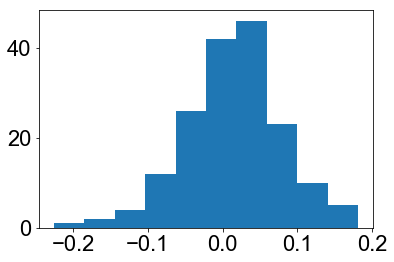

In [127]:
plt.hist(diff[~np.isnan(diff)])

In [135]:
sel = ~np.isnan(diff)
_diff   = diff[sel]
_resids = resids[sel]
_resids[np.argsort(-_diff)][:5]

array([107, 170, 109,  40,  99], dtype=int32)

# Predictions on known variants

In [67]:
sel = r_full.predictions['training info'] != 'new'
print(r_full.predictions[sel])

[(0.94666666, 0.9177322 , 'deleterious', 'known_del')
 (0.904     , 0.83405364, 'deleterious', 'known_del')
 (0.96066666, 0.9472296 , 'deleterious', 'known_del')
 (0.938     , 0.89855886, 'deleterious', 'known_del')
 (0.9266667 , 0.87348604, 'deleterious', 'known_del')
 (0.96466666, 0.9472296 , 'deleterious', 'known_del')
 (0.92733335, 0.8749609 , 'deleterious', 'known_del')
 (0.924     , 0.86758655, 'deleterious', 'known_del')
 (0.9206667 , 0.86021215, 'deleterious', 'known_del')
 (0.9353333 , 0.89265937, 'deleterious', 'known_del')
 (0.958     , 0.94280505, 'deleterious', 'known_del')
 (0.8386667 , 0.6880464 , 'deleterious', 'known_del')
 (0.89666665, 0.8227403 , 'deleterious', 'known_del')
 (0.87666667, 0.7880518 , 'deleterious', 'known_del')
 (0.948     , 0.92068195, 'deleterious', 'known_del')
 (0.97533333, 0.9472296 , 'deleterious', 'known_del')
 (0.97066665, 0.9472296 , 'deleterious', 'known_del')]


In [121]:
np.nanstd(diff)

0.066239275

In [126]:
diff[np.isnan(diff)]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan], dtype=float32)

### Training of unbiased classifiers